In [21]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


In [22]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# --- FIX: Preserve test_df trip_id for final submission ---
# The modeling script needs the original test trip_id for the submission file.
# Save this column now before we drop it later in preprocessing.
test_raw = test_df[['trip_id']].copy()
test_raw.to_csv("test_raw.csv", index=False)
print("Saved test_raw.csv containing 'trip_id'.")

print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")


Saved test_raw.csv containing 'trip_id'.
Train Data Shape: (12654, 25)
Test Data Shape: (5852, 24)


In [23]:
missing_count = train_df['spend_category'].isnull().sum()

# 3. Check for missing values represented by empty strings (if the column is a string type)
if train_df['spend_category'].dtype == 'object':
    empty_string_count = (train_df['spend_category'] == '').sum()
else:
    empty_string_count = 0

total_missing = missing_count + empty_string_count
total_rows = len(train_df)


print(f"Total rows in train_df: {total_rows}")
print(f"Missing (NaN/None) count: {missing_count}")
print(f"Missing (Empty string) count: {empty_string_count}")
print(f"Total missing values in 'spend_category': {total_missing}")


Total rows in train_df: 12654
Missing (NaN/None) count: 34
Missing (Empty string) count: 0
Total missing values in 'spend_category': 34


In [24]:
train_df.dropna(subset=['spend_category'], inplace=True)
missing_count_1 = train_df['spend_category'].isnull().sum()

print(f"Total rows in train_df: {len(train_df)}")
print(f"Missing (NaN/None) count: {missing_count_1}")

Total rows in train_df: 12620
Missing (NaN/None) count: 0


In [25]:
# --- FIX: Modify concatenation and dropping logic ---
TARGET = 'spend_category'

# 1. Separate the target from the train features, but keep target index aligned
# This 'target' variable contains the cleaned 'spend_category' with the correct index
target = train_df[TARGET].astype(int)
train_features_df = train_df.drop(columns=[TARGET]) # Create a copy of features without target

# 2. Drop 'trip_id' ONLY from the feature sets we are processing
# This ensures train_features_df and test_features_df have identical columns for concatenation
train_features_df = train_features_df.drop('trip_id', axis=1)
test_features_df = test_df.drop('trip_id', axis=1)

# 3. Add 'source' column for splitting later
train_features_df['source'] = 'train'
test_features_df['source'] = 'test'

# 4. Concatenate for consistent preprocessing
combined_df = pd.concat([train_features_df, test_features_df], ignore_index=True)

print(f"Combined Data Shape (Features only, no trip_id/target): {combined_df.shape}")

Combined Data Shape (Features only, no trip_id/target): (18472, 24)


In [26]:
# removing columns with many missing values

missing_data = combined_df.isnull().sum()
total_rows = len(combined_df)
missing_percentage = (missing_data / total_rows) * 100
missing_summary = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

print(missing_summary.to_string())

has_special_requirements    63.945431
arrival_weather             27.003032
days_booked_before_trip     11.985708
travel_companions            5.797964
total_trip_days              3.004547
country                      1.911000
insurance_included           1.851451
food_included                1.347986
intl_transport_included      1.098961
accomodation_included        1.098961
main_activity                1.044825
is_first_visit               0.741663
age_group                    0.043309
num_males                    0.032482
num_females                  0.010827


In [27]:
# --- 1. Utilizing has_special_requirements (Binary Parsing) ---

# Replace missing values (NaN) with an empty string for safe string operations
combined_df['has_special_requirements'] = combined_df['has_special_requirements'].fillna('')

# Clean and standardize the column content: remove spaces, strip trailing commas, convert to lower case
combined_df['has_special_requirements'] = (
    combined_df['has_special_requirements']
    .str.replace(' ', '')
    .str.strip(',')
    .str.lower()
)

# Identify all unique requirement types across the dataset
all_requirements = set()
for requirements_str in combined_df['has_special_requirements'].unique():
    if requirements_str:
        # Split by comma to get individual requirements
        for req in requirements_str.split(','):
            all_requirements.add(req)

print(f"Identified unique requirements: {all_requirements}")

# Create a new binary column (req_*) for each unique requirement type
for req in sorted(list(all_requirements)):
    col_name = f'req_{req.replace(" ", "_")}'
    # 1 if the requirement string contains the requirement, 0 otherwise
    combined_df[col_name] = combined_df['has_special_requirements'].str.contains(req).astype(int)

# Create an indicator for "No Special Requirements" (where the string is empty)
combined_df['req_none'] = (combined_df['has_special_requirements'] == '').astype(int)

# Drop the original column
combined_df.drop(columns=['has_special_requirements'], inplace=True)

Identified unique requirements: {'wheelchair', 'dietaryneeds', 'none', 'translatorrequired.'}


In [28]:
#for train specific tasks
train_mask = combined_df['source'] == 'train'

In [29]:
numerical_cols = combined_df.select_dtypes(include=np.number).columns.tolist()
# Numerical Imputation (Median)
for col in numerical_cols:
    # 1. Calculate median ONLY on the training subset
    train_median = combined_df.loc[train_mask, col].median()
    
    # 2. Apply this single median value to fill NaNs in the entire column (train + test)
    combined_df[col].fillna(train_median, inplace=True)

/tmp/ipykernel_10294/2005190108.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df[col].fillna(train_median, inplace=True)
/tmp/ipykernel_10294/2005190108.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [30]:
categorical_cols = combined_df.select_dtypes(include=['object']).columns.tolist()
# Remove 'source' from categorical_cols
categorical_cols.remove('source')
for col in categorical_cols:
    if combined_df[col].isnull().any():
        # Fill with a specific string for clarity, or use mode for high frequency
        combined_df[col].fillna('Missing', inplace=True)

/tmp/ipykernel_10294/332126211.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df[col].fillna('Missing', inplace=True)


In [31]:
missing_data = combined_df.isnull().sum()
total_rows = len(combined_df)
missing_percentage = (missing_data / total_rows) * 100
missing_summary = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

print(missing_summary.to_string())

Series([], )


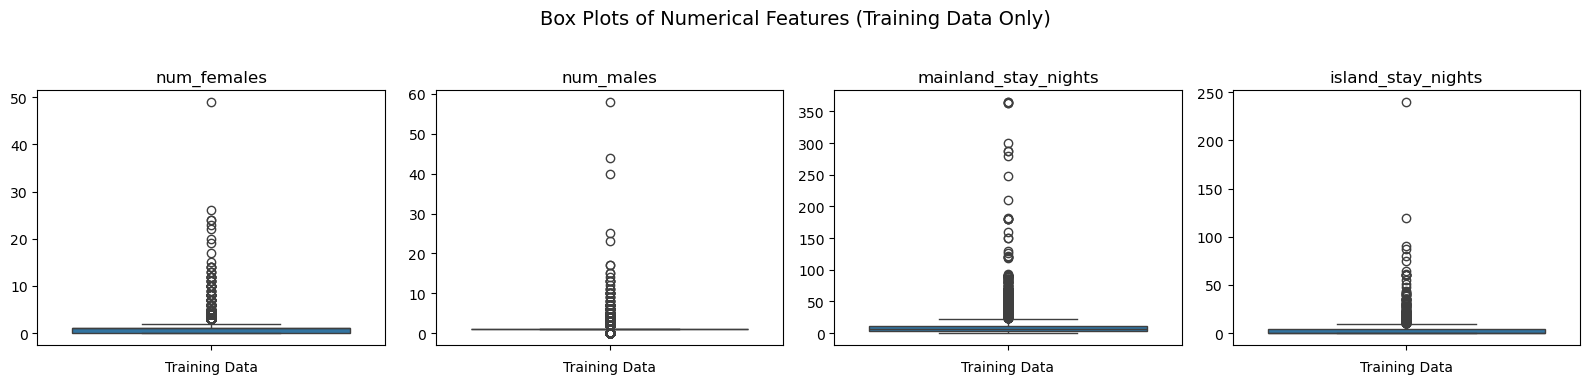

In [32]:

import matplotlib.pyplot as plt
import seaborn as sns

outlier_cols = ['num_females', 'num_males', 'mainland_stay_nights', 'island_stay_nights']


train_data = combined_df[train_mask]

# Create box plots for visualization
plt.figure(figsize=(16, 4))
plt.suptitle('Box Plots of Numerical Features (Training Data Only)', fontsize=14)

for i, col in enumerate(outlier_cols):
    plt.subplot(1, 4, i + 1)
    # Plotting using ONLY the training subset
    sns.boxplot(y=train_data[col])
    plt.title(f'{col}')
    plt.ylabel('')
    plt.xlabel('Training Data')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])#

Interquartile Range (IQR) method
Any data point that falls outside the range below will be capped or removed:

$$[Q1 - 1.5 \times IQR, \quad Q3 + 1.5 \times IQR]$$

In [33]:
numerical_cols_to_cap = ['num_females', 'num_males', 'mainland_stay_nights', 'island_stay_nights']


# Loop through columns and calculate bounds ONLY on training data, then apply to the whole column.
for col in numerical_cols_to_cap:
    
    # 1. CALCULATE BOUNDS USING ONLY TRAINING DATA (Leakage Prevention)
    Q1 = combined_df.loc[train_mask, col].quantile(0.25)
    Q3 = combined_df.loc[train_mask, col].quantile(0.75)
    IQR = Q3 - Q1

    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    # Enforce lower bound >= 0 (retaining the original logic for count data)
    if lower_bound < 0:
        lower_bound = 0

    # 2. APPLY CALCULATED BOUNDS to the ENTIRE COLUMN (Train and Test)
    
    # Apply upper cap
    combined_df[col] = combined_df[col].apply(
        lambda x: upper_bound if x > upper_bound else x
    )
    
    # Apply lower cap
    combined_df[col] = combined_df[col].apply(
        lambda x: lower_bound if x < lower_bound else x
    )
    

# Note: You should re-run your full data preparation script 
# with this updated capping logic incorporated in step 2.

In [34]:
# Total number of travelers
combined_df['total_travelers'] = combined_df['num_females'] + combined_df['num_males']

# Total stay nights
combined_df['total_stay_nights'] = combined_df['mainland_stay_nights'] + combined_df['island_stay_nights']

# Trip Type feature
def get_trip_type(row):
    is_mainland = row['mainland_stay_nights'] > 0
    is_island = row['island_stay_nights'] > 0
    if is_mainland and is_island:
        return 'Both'
    elif is_mainland:
        return 'Mainland Only'
    elif is_island:
        return 'Island Only'
    else:
        return 'No Stay'
combined_df['trip_type'] = combined_df.apply(get_trip_type, axis=1)
categorical_cols.append('trip_type')

ORDINAL MAPPING

Mapping range columns to mid point of the range

In [35]:


# --- A. UPDATED Range Mapping Function and Application ---

def map_range_to_midpoint_NEW(range_str):
    """
    Converts a closed range string (e.g., '1-7') to its numerical midpoint.
    Returns np.nan for open-ended ranges ('30+', '90+'), 'none', 'Missing', or actual NaNs.
    """
    # Standardize string for comparison
    range_str = str(range_str).strip()
    
    # Check for values that should NOT be converted to a midpoint
    if range_str in ['nan', 'Missing', 'none', '30+', '90+', '']:
        return np.nan
        
    try:
        if '-' in range_str:
            # Safely extract numbers from the range string
            numbers = re.findall(r'\d+', range_str)
            if len(numbers) == 2:
                start, end = map(float, numbers)
                return (start + end) / 2
        else:
            # Handle single number values if they exist
            return float(range_str)
    except:
        return np.nan # Return NaN for unparseable/junk strings

# Apply the new midpoint mapping (midpoint features now contain NaNs for open-ended/missing)
combined_df['days_booked_midpoint'] = combined_df['days_booked_before_trip'].apply(map_range_to_midpoint_NEW)
combined_df['total_trip_days_midpoint'] = combined_df['total_trip_days'].apply(map_range_to_midpoint_NEW)

# --- B. Create Explicit Structural and Missing Flags ---

# 1. Create flags for the open-ended ranges ('30+' and '90+')
# This captures the significance of these categories without arbitrary numerical assignment
combined_df['days_booked_open_ended'] = combined_df['days_booked_before_trip'].astype(str).str.contains(r'30\+|90\+').astype(int)
combined_df['total_trip_days_open_ended'] = combined_df['total_trip_days'].astype(str).str.contains(r'30\+|90\+').astype(int)

# 2. Create flags for 'none' (which is often a specific category in survey data)
combined_df['days_booked_none'] = combined_df['days_booked_before_trip'].astype(str).str.contains(r'none').astype(int)
combined_df['total_trip_days_none'] = combined_df['total_trip_days'].astype(str).str.contains(r'none').astype(int)

# 3. Create flags for truly missing/unhandled values (these are now separated from the features above)
combined_df['days_booked_missing'] = combined_df['days_booked_before_trip'].isna().astype(int)
combined_df['total_trip_days_missing'] = combined_df['total_trip_days'].isna().astype(int)
combined_df['age_group_missing'] = combined_df['age_group'].isna().astype(int)


# --- C. Imputation for New Midpoint Features ---

# Impute the new numerical midpoint columns with the median of the NON-open-ended/NON-missing values
median_db = combined_df['days_booked_midpoint'].median()
median_ttd = combined_df['total_trip_days_midpoint'].median()

combined_df['days_booked_midpoint'].fillna(median_db, inplace=True)
combined_df['total_trip_days_midpoint'].fillna(median_ttd, inplace=True)


# --- D. Age Group Mapping (Remains the Same) ---

# Mapping age_group (a simpler Ordinal feature)
age_mapping = {'<18': 10, '18-24': 21, '25-44': 35, '45-64': 55, '65+': 70, 'Missing': 0}
combined_df['age_group_ordinal'] = combined_df['age_group'].map(age_mapping).fillna(0)

/tmp/ipykernel_10294/30000206.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['days_booked_midpoint'].fillna(median_db, inplace=True)
/tmp/ipykernel_10294/30000206.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

Advanced Feature Engineering

In [36]:
# 1. Stay Length x Travelers (Spending Volume)
combined_df['nights_per_traveler'] = combined_df['total_stay_nights'] / (combined_df['total_travelers'] + 1e-6) # Add epsilon to avoid division by zero
combined_df['nights_x_travelers'] = combined_df['total_stay_nights'] * combined_df['total_travelers']

# 2. Main/Island Stay Ratio (Trip Focus)
combined_df['main_island_ratio'] = combined_df['mainland_stay_nights'] / (combined_df['island_stay_nights'] + 1e-6)
combined_df['total_stay_nights'] = combined_df['mainland_stay_nights'] + combined_df['island_stay_nights'] # Ensure this total is correct

# 3. Service Level (Sum of Included Services)
service_cols = ['accomodation_included', 'food_included', 'domestic_transport_included', 
                'sightseeing_included', 'guide_included', 'insurance_included']

# Convert 'Yes'/'No'/Missing to a numerical score (0, 1, or NaN)
for col in service_cols:
    combined_df[col + '_flag'] = combined_df[col].map({'Yes': 1, 'No': 0}).fillna(np.nan)

# Create a sum of included services
combined_df['total_services_included'] = combined_df[[col + '_flag' for col in service_cols]].sum(axis=1)

# Drop the temporary flag columns after summing
combined_df.drop(columns=[col + '_flag' for col in service_cols], inplace=True)

In [37]:
# 4. Traveler Mix Features
# Use num_females and num_males which are available in the raw data
combined_df['total_travelers_actual'] = combined_df['num_females'] + combined_df['num_males']
combined_df['female_ratio'] = combined_df['num_females'] / (combined_df['total_travelers_actual'] + 1e-6)

# Create a flag for single female or single male travelers
combined_df['solo_female'] = ((combined_df['num_females'] == 1) & (combined_df['num_males'] == 0)).astype(int)
combined_df['solo_male'] = ((combined_df['num_males'] == 1) & (combined_df['num_females'] == 0)).astype(int)

Cleanup

In [38]:
# Drop original ordinal columns
combined_df = combined_df.drop(['days_booked_before_trip', 'total_trip_days', 'age_group'], axis=1)

One-Hot Encoding

In [39]:
# --- NEW CODE BLOCK: ONE-HOT ENCODING ---

# Assuming 'combined_df' now contains all cleaned and imputed features, plus the 'source' column.

# 1. Separate 'source' column for splitting
source_col = combined_df['source']
combined_df = combined_df.drop(columns=['source'])

train_country_counts = combined_df.loc[train_mask, 'country'].value_counts()
country_freq_map = (train_country_counts / len(train_country_counts)).to_dict()

# 2. Map the frequency back to the entire column (train + test)
combined_df['country_freq_enc'] = combined_df['country'].map(country_freq_map)

# 3. Handle unseen test values: Map sets NaNs for countries not in the training set.
# Impute these NaNs with 0 or the mean frequency of the training set. 
# We'll use 0, implying a country with no prior observed frequency.
combined_df['country_freq_enc'].fillna(0, inplace=True) 

# 4. Drop the original column
combined_df.drop(columns=['country'], inplace=True)
# 2. Perform One-Hot Encoding on all remaining object columns
# This transforms remaining categorical columns into a numerical format.
categorical_cols_to_encode = combined_df.select_dtypes(include=['object']).columns.tolist()
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols_to_encode, drop_first=True, dtype=int)

# 3. Re-attach the 'source' column for splitting
combined_df_encoded['source'] = source_col

print(f"Encoded Combined Data Shape: {combined_df_encoded.shape}")



# 4. Scaling: Normalize features for distance-based models (LR, SVM, NB)




# --- NEW CODE BLOCK: SPLITTING AND SAVING ---
TARGET = 'spend_category'

# 1. Split back into Training Features and Test Features
train_processed = combined_df_encoded[combined_df_encoded['source'] == 'train'].drop(columns=['source'])
test_processed = combined_df_encoded[combined_df_encoded['source'] == 'test'].drop(columns=['source'])

# 2. Align the index of the training features to the target and add the target column back
# This alignment is necessary because we dropped rows with NaN in the target earlier.
train_processed.index = target.index
train_processed[TARGET] = target # Include target in the final processed training file

# 3. Save Final Processed Files
train_processed.to_csv("train_processed.csv", index=False)
test_processed.to_csv("test_processed.csv", index=False)

print("\nFinished Preprocessing and saving files.")
print(f"train_processed.csv saved with shape: {train_processed.shape}")
print(f"test_processed.csv saved with shape: {test_processed.shape}")

/tmp/ipykernel_10294/1858966770.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['country_freq_enc'].fillna(0, inplace=True)


Encoded Combined Data Shape: (18472, 82)

Finished Preprocessing and saving files.
train_processed.csv saved with shape: (12620, 82)
test_processed.csv saved with shape: (5852, 81)
